In [1]:
#Import Relevant Libraries
import random
import numpy as np
import cvxpy as cp

from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector

from qiskit import quantum_info as qi
from toqito.channel_metrics import channel_fidelity

from toqito.state_metrics import fidelity
from toqito.channels import partial_trace as pt
from qiskit.quantum_info import DensityMatrix, state_fidelity, partial_trace

In [2]:
def prune(oper):
    for i in range(oper.shape[0]):
        for j in range(oper.shape[1]):
            x = np.real(oper[i, j])
            y = np.imag(oper[i, j])
            tx = np.round_(x, 15)
            ty = np.round_(y, 15)
            oper[i, j] = tx + 1j*ty
    return oper

In [3]:
I = np.array([[1, 0], [0, 1]])
U1_1qubit = np.array([[1, 0], [0, 1j]], dtype=complex)
U1 = np.kron(np.kron(U1_1qubit, U1_1qubit), U1_1qubit)
U2 = np.matmul(U1, U1)
U3 = np.matmul(U2, U1)

In [4]:
lis = []
lis.append(np.kron(I, np.kron(I, I)))
lis.append(U1)
lis.append(U2)
lis.append(U3)

In [5]:
Pi_SR = np.zeros(np.kron(I, np.kron(I, I)).shape, dtype=complex)
for item in lis:
    Pi_SR += (1/len(lis))*item
print(Pi_SR)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [6]:
unitary_param_1 = [4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712,
                   3.44120060, 3.24526326, 0.91836107, 1.32971456, 4.80863498, 0.54593609]

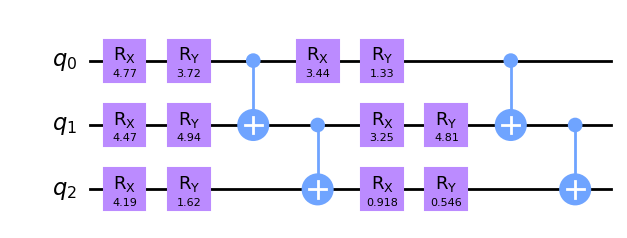

In [7]:
#State \rho_SR
size = 3
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

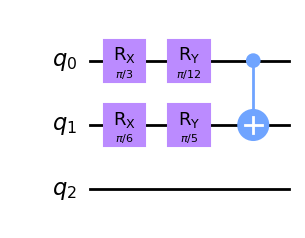

In [199]:
qcTest = QuantumCircuit(3)
qcTest.rx(np.pi/3, 0)
qcTest.rx(np.pi/6, 1)
qcTest.ry(np.pi/12, 0)
qcTest.ry(np.pi/5, 1)
qcTest.cx(0, 1)
qcTest.draw('mpl')

In [193]:
backend = Aer.get_backend('statevector_simulator')
result = execute(qcTest.reverse_bits(), backend).result().get_statevector()
for i in range(len(result)):
    if np.abs(result[i])>=1e-6:
        print(i, result[i])

0 (0.7835483246777085+0.12862564561878498j)
2 (0.27235088137987856-0.1918695394474524j)
4 (-0.08828211190428426-0.17579167031041873j)
6 (0.14349090553128707-0.4463546357155223j)


In [197]:
psi = np.array(DensityMatrix.from_instruction(qcTest.reverse_bits()))
rho = prune(pt(psi, [2, 3], [2, 2, 2])) #rho_S
print(rho)

[[0.74148146+0.j         0.03293712+0.22041947j]
 [0.03293712-0.22041947j 0.25851854+0.j        ]]


In [198]:
shape = rho.shape

X = cp.Variable(shape, complex=True)
omega = cp.Variable(Pi_SR.shape, complex=True)
G = cp.bmat([[rho, X.H],[X, pt(omega, [2, 3], [2, 2, 2])]])

c = [omega>>0, G>>0, cp.real(cp.trace(omega))==1]

c.append(omega == Pi_SR@omega@Pi_SR)

obj = cp.Maximize(cp.real(cp.trace(X)))
problem = cp.Problem(obj, constraints = c)
rootFid = problem.solve()
print("Root Fidelity is : " + str(rootFid))

WARN: A->p (column pointers) not strictly increasing, column 68 empty
WARN: A->p (column pointers) not strictly increasing, column 68 empty
Root Fidelity is : 0.8638952525690888


In [196]:
print("Fidelity is : " + str(rootFid**2))

Fidelity is : 0.7463150074114098
